In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm

#Bank Marketing source data is available at https://archive.ics.uci.edu/ml/datasets/bank+marketing

#Imports the CSVs, cleans up the formatting and creates a ledgible dataframe
df = (pd.read_csv('C:/Users/rockn/Downloads/bank/bank-full.csv', delimiter = ";", header = None, low_memory = False)).replace('"', '', regex=True)

df.columns = df.iloc[0]
df = df[1:]
df.reset_index(drop = True, inplace = True)
df.shape

#Sets default figure size for all matplotlib charts
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.xmargin'] = 0

C:\Users\rockn\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print('Beginning with data pre-processing, we confirm binary features to binary values, convert numerical features to numeric data types and set dates to the monthly format.')

#Reclassifies yes and no values into 0's and 1's 
df[['default', 'housing', 'loan', 'y']] = df[['default', 'housing', 'loan', 'y']].replace({'yes' : 1, 'no' : 0})

df['poutcome'].replace({'other' : 0, 'failure' : 0, 'unknown' : 0, 'success' : 1}, inplace = True)

#Converts months into numeric value(1 for Jan, 12 for December)
df['month'] = pd.to_datetime(df['month'], format = '%b').dt.month

#Reassign values to numeric if applicable
df[['age', 'balance','month', 'duration', 'campaign', 'pdays']] = df[['age', 'balance', 'month', 'duration', 'campaign', 'pdays']].apply(pd.to_numeric)


Beginning with data pre-processing, we confirm binary features to binary values, convert numerical features to numeric data types and set dates to the monthly format.


In [3]:
#Identifies percetage of records with missing data per feature
df[df == 'unknown'] = np.nan
percent_missing = df.isnull().mean() * 100
print(percent_missing)
df = df.apply(lambda x: x.replace(np.nan, f'unknown_{x.name}'))

#Contact and previous campaign outcome have a high amount of missing values
#Contact will be dropped for the time being
df.drop(columns = ['contact'], inplace = True)


0
age           0.000000
job           0.637013
marital       0.000000
education     4.107407
default       0.000000
balance       0.000000
housing       0.000000
loan          0.000000
contact      28.798301
day           0.000000
month         0.000000
duration      0.000000
campaign      0.000000
pdays         0.000000
previous      0.000000
poutcome      0.000000
y             0.000000
dtype: float64


C:\Users\rockn\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\rockn\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\rockn\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\rockn\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
C:\Users\rockn\Anaconda3\lib\site-packages\pandas\core\computation\expressions.p

In [4]:
print('Continuing to make minor amendments to data values to simplify analysis.')

#Cleans up pdays. -1 represents applicants who are net new to marketing 
# campaigns and have not been contacted previously
df['pdays'] = df['pdays'].replace(to_replace = -1, value = 0)

#Aggregating some of the jobs entered for simplicity
#Bucketing some of the jobs
df['job'].replace('entrepreneur', 'self-employed', inplace = True)
df['job'].replace('housemaid', 'services', inplace = True)

#Rename some ambigious columns into more understandable values
df.rename(columns = {'campaign' : 'current_touchpoint_count', 'pdays' : 'days_since_last_campaign', 
                                'previous': 'previous_campaign_touchpoint_count', 
                                'poutcome':'previous_campaign_outcome', 'y':'target'}, inplace = True)

df[['job', 'marital', 'education']] = df[['job', 'marital', 'education']].astype('category')

Continuing to make minor amendments to data values to simplify analysis.


In [5]:
#Begin EDA, describe numerical features
print('Exploring the numerical features.\n')
print(df.describe())

print('\n' + """Looking at the numerical features we can see a few interesting insights.
1. With regards to account balances, the mean account balance is around 1,400 and 75% of clients have 1,400 or less in their account.
2. A very small portion of our clients have defaulted, about 2% overall.
3. Within the housing feature, about half of the clients targetted have a mortgage and own real estate property.
4. The average call lasts about 260 seconds or about 4 minutes and 20 seconds.
5. In the current campaign, a client has about 3 calls within the campaign. 
6. 75% of clients contacted in this campaign have not been previously contacted before, this is denoted by 0 within days_since_last_campaign.\n""")

Exploring the numerical features.

0               age       default        balance       housing          loan  \
count  45211.000000  45211.000000   45211.000000  45211.000000  45211.000000   
mean      40.936210      0.018027    1362.272058      0.555838      0.160226   
std       10.618762      0.133049    3044.765829      0.496878      0.366820   
min       18.000000      0.000000   -8019.000000      0.000000      0.000000   
25%       33.000000      0.000000      72.000000      0.000000      0.000000   
50%       39.000000      0.000000     448.000000      1.000000      0.000000   
75%       48.000000      0.000000    1428.000000      1.000000      0.000000   
max       95.000000      1.000000  102127.000000      1.000000      1.000000   

0             month      duration  current_touchpoint_count  \
count  45211.000000  45211.000000              45211.000000   
mean       6.144655    258.163080                  2.763841   
std        2.408034    257.527812                  3.09

In [6]:
#Creating one additional categorization for EDA purposes
#Categorize individuals who have a mortgage, loan, mortgage + loan or neither
conditions = [(df['housing'] == 1) & (df['loan'] == 1),
            (df['housing'] == 1) & (df['loan'] == 0),
            (df['housing'] == 0) & (df['loan'] == 1),
            (df['housing'] == 0) & (df['loan'] == 0)]
outcomes = ['Mortgage & Loan', 'Mortgage Only', 'Loan Only', 'No Mortgage or Loan']

df['classification'] = np.select(conditions, outcomes)

print('For categorical features, we have the following breakdown of values.')
#Value counts for categorical features
for value in ['job', 'marital', 'education', 'classification']:

    print(f'\nFor the {value} feature')
    print(df[value].value_counts())

For categorical features, we have the following breakdown of values.

For the job feature
blue-collar      9732
management       9458
technician       7597
services         5394
admin.           5171
self-employed    3066
retired          2264
unemployed       1303
student           938
unknown_job       288
Name: job, dtype: int64

For the marital feature
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

For the education feature
secondary            23202
tertiary             13301
primary               6851
unknown_education     1857
Name: education, dtype: int64

For the classification feature
Mortgage Only          20763
No Mortgage or Loan    17204
Mortgage & Loan         4367
Loan Only               2877
Name: classification, dtype: int64


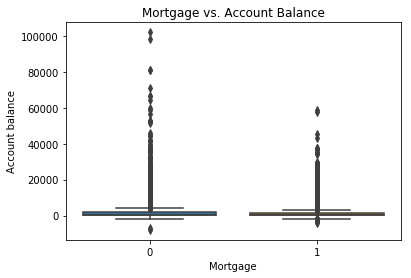

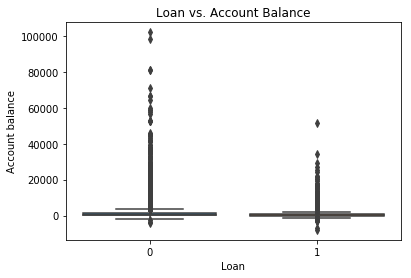

Those with existing loans and mortgages generally have fewer outliers.
Overall, those with existing loans and mortgages have a marginally lower median balance.


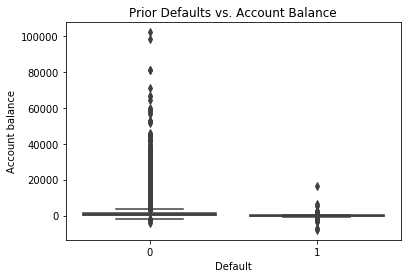

Those who have previously defaulted share a similar median balance.
However, those who previously defaulted generally have less outliers


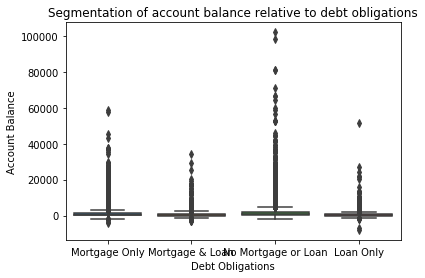

Median account balance is similar for the various categories of debt obligations.
Fewer obligations generally results in higher account balances in the outliers.


In [7]:
#Box plots
sns.boxplot(x='housing', y='balance', data=df)
plt.title('Mortgage vs. Account Balance')
plt.xlabel('Mortgage')
plt.ylabel('Account balance')
plt.show()

sns.boxplot(x='loan', y='balance', data=df)
plt.title('Loan vs. Account Balance')
plt.xlabel('Loan')
plt.ylabel('Account balance')
plt.show()
print("""Those with existing loans and mortgages generally have fewer outliers.
Overall, those with existing loans and mortgages have a marginally lower median balance.""")

sns.boxplot(x='default', y='balance', data=df)
plt.title('Prior Defaults vs. Account Balance')
plt.xlabel('Default')
plt.ylabel('Account balance')
plt.show()
print("""Those who have previously defaulted share a similar median balance.
However, those who previously defaulted generally have less outliers""")



sns.boxplot(x = 'classification', y = 'balance', data = df)
plt.title('Segmentation of account balance relative to debt obligations')
plt.xlabel('Debt Obligations')
plt.ylabel('Account Balance')
plt.show()
print("""Median account balance is similar for the various categories of debt obligations.
Fewer obligations generally results in higher account balances in the outliers.""")

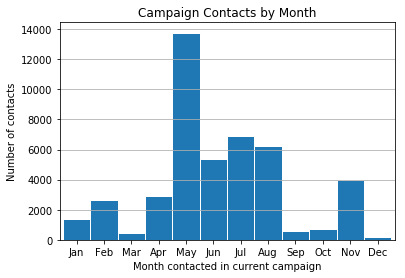

The majority of capaign activitiy occurs in the summer months.


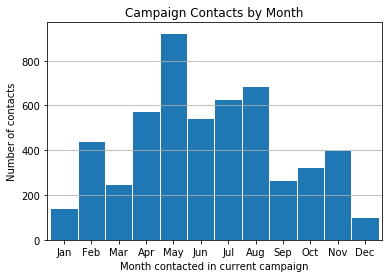

Specific to clients successfully upsold, the majority of activity occurs in the summer months as well as February, October and November.


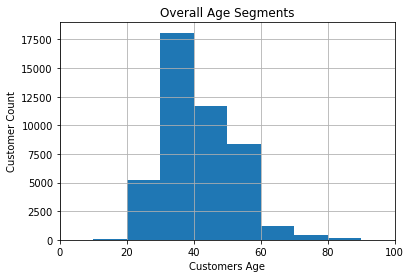

The age of customers contacted skews towards the right, an older demographic.


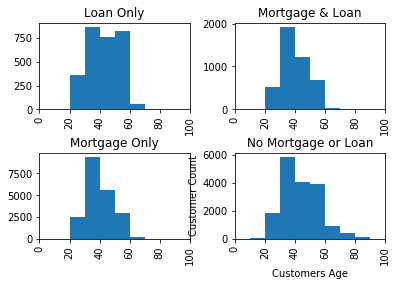

Customers with a mortgage or no debt obligations skew to an older demographic.
Those with only a loan are more normally distributed.


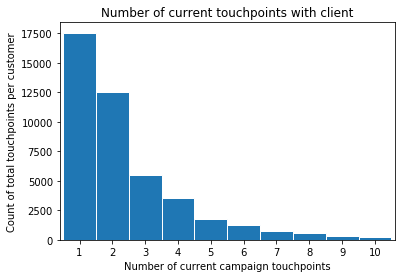

The majority of current campaigns have around 1 to 4 touchpoints with a customer


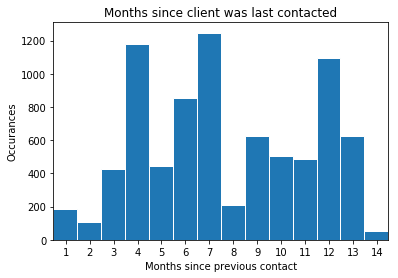

The majority of customers that were contacted occured 7, 4, 12 and 6 months ago.
Customers are generally not contacted until after 3 months since they were targetted in the last campaign


In [8]:
#Histograms
#Look at month clients had been contacted in the current campaign 
df['month'].hist(bins=np.arange(0.5, 13, 1), edgecolor='white')
plt.title('Campaign Contacts by Month')
plt.xlabel('Month contacted in current campaign')
plt.ylabel('Number of contacts')
plt.xticks(ticks=range(1, 13),
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(False, axis = 'x')
plt.margins(x=0.01)
plt.show()
print('The majority of capaign activitiy occurs in the summer months.')

#Looking specifically at contact times where clients were successfully upsold
df['month'][df['target'] == 1].hist(bins=np.arange(0.5, 13, 1), edgecolor='white')
plt.title('Campaign Contacts by Month')
plt.xlabel('Month contacted in current campaign')
plt.ylabel('Number of contacts')
plt.xticks(ticks = range(1, 13),
           labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(False, axis = 'x')
plt.margins(x=0.01)
plt.show()
print('Specific to clients successfully upsold, the majority of activity occurs in the summer months as well as February, October and November.')

#Histogram of overall age segments in binned in 10 year bins
df['age'].hist(bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.title('Overall Age Segments')
plt.xlabel('Customers Age')
plt.ylabel('Customer Count')
plt.show()
print('The age of customers contacted skews towards the right, an older demographic.')

#Histogram of overall age segments in binned in 10 year bins segmented by loan & mortgage classifications
df['age'].hist(by = df['classification'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xlabel('Customers Age')
plt.ylabel('Customer Count')
plt.show()
print("""Customers with a mortgage or no debt obligations skew to an older demographic.
Those with only a loan are more normally distributed.""")

#Analyze current touch point count
plt.hist(df['current_touchpoint_count'], bins = np.arange(0.5, 11, 1), range = (0.5, 11), edgecolor = 'white')
plt.xticks(ticks = range(1, 11), labels = range(1,11))
plt.title('Number of current touchpoints with client')
plt.xlabel('Number of current campaign touchpoints')
plt.ylabel('Count of total touchpoints per customer')
plt.margins(x=0.01)
plt.show()
print('The majority of current campaigns have around 1 to 4 touchpoints with a customer')

#Omitting those who had not been previously contacted before (0's)
plt.hist(df['days_since_last_campaign'], bins = np.arange(0.5,15*30,30), range = (1, 420), align = 'left', edgecolor = 'white')
plt.xticks(ticks = np.arange(1, 420, 30), labels = np.arange(1, 15, 1))
plt.title('Months since client was last contacted')
plt.xlabel('Months since previous contact')
plt.ylabel('Occurances')
plt.show()
print("""The majority of customers that were contacted occured 7, 4, 12 and 6 months ago.
Customers are generally not contacted until after 3 months since they were targetted in the last campaign""")

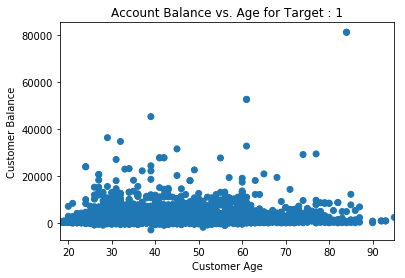

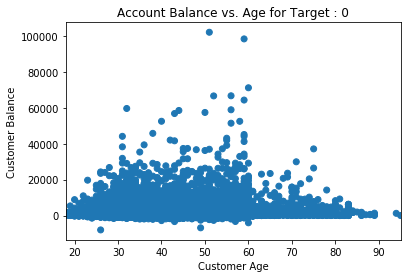

When comparing balance and age profiles of both target groups, both groups have a similar distribution.


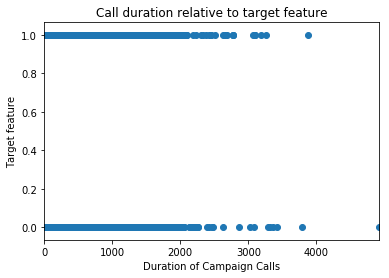

There does not seem to be a significant distinction in the length of calls for those who successfully convert vs. those who do not.


In [9]:
#Scatterplots
#Scatter plot of account balance for target 1
plt.scatter(df['age'][df['target'] == 1], df['balance'][df['target'] == 1], c = df['target'][df['target'] == 1], cmap = 'tab10')
plt.title('Account Balance vs. Age for Target : 1')
plt.xlabel('Customer Age')
plt.ylabel('Customer Balance')
plt.show()

#Scatter plot of account balance for target 0
plt.scatter(df['age'][df['target'] == 0], df['balance'][df['target'] == 0], c = df['target'][df['target'] == 0], cmap = 'tab10')
plt.title('Account Balance vs. Age for Target : 0')
plt.xlabel('Customer Age')
plt.ylabel('Customer Balance')
plt.show()
print('When comparing balance and age profiles of both target groups, both groups have a similar distribution.')

#Check call duration vs. target 
plt.scatter(df['duration'], df['target'])
plt.title('Call duration relative to target feature')
plt.xlabel('Duration of Campaign Calls')
plt.ylabel('Target feature')
plt.show()
print('There does not seem to be a significant distinction in the length of calls for those who successfully convert vs. those who do not.')


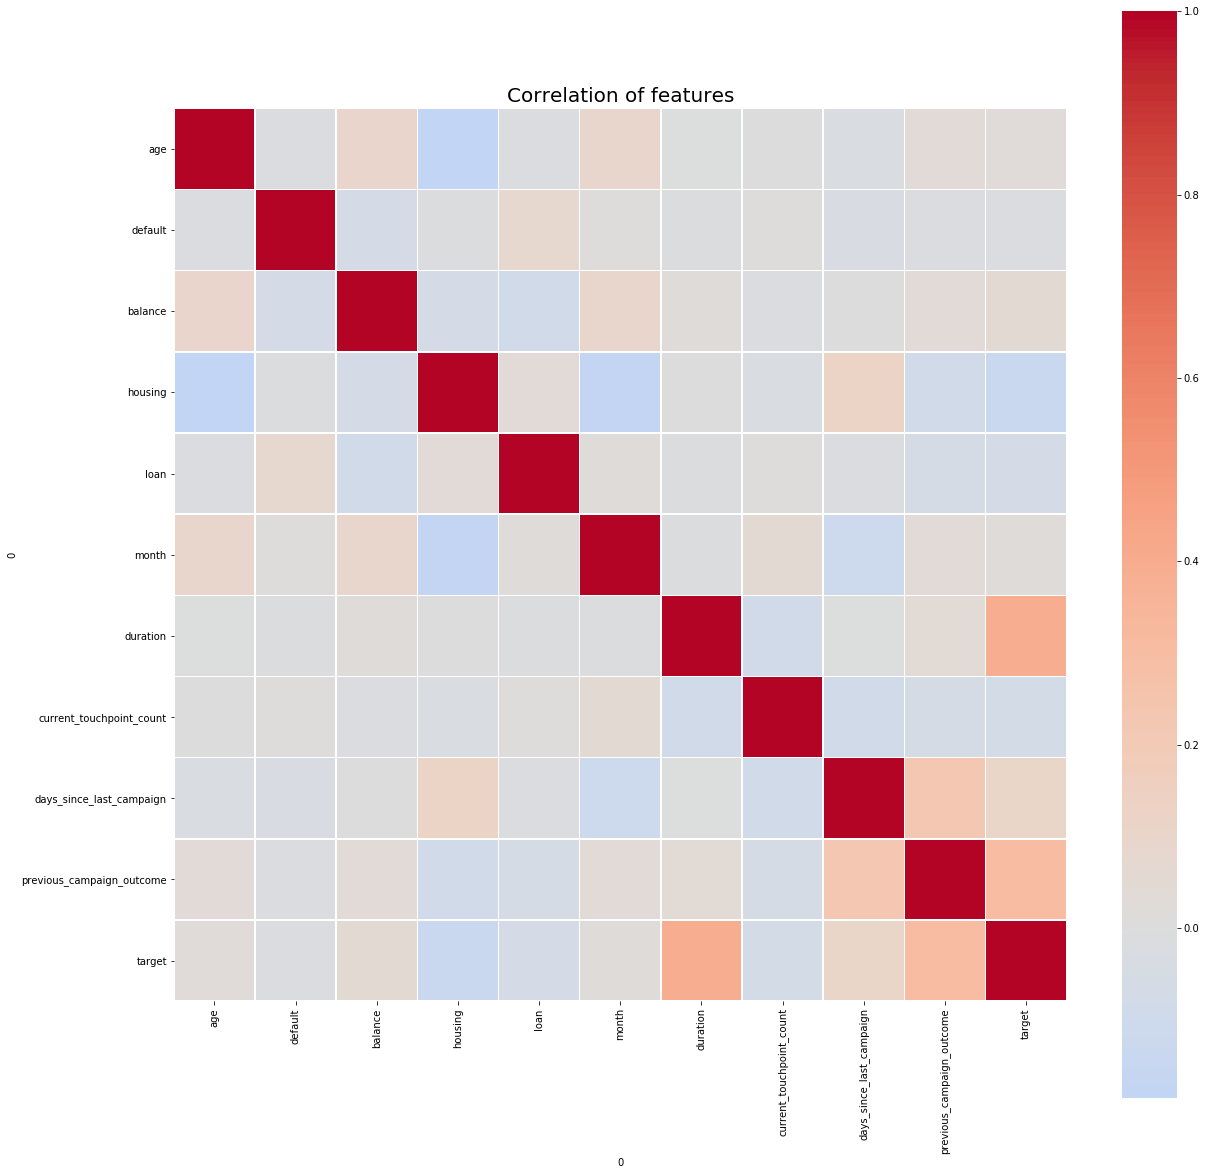

The strongest correlation between successfully upselling our customers is tied to the length of the call.
Additionally, the previous campaign outcome is also moderately correlated with the success of the current campaign.
There is lower correlation with the previous number of campaign touchpoint as well.


In [10]:
#Create correlation matrix for all non-categorical values
corr = df[~df.isin(['job', 'marital', 'education'])].corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corr, cmap = 'coolwarm', center=0, square=True, linewidths=.5)
plt.title('Correlation of features', fontsize = 20)
plt.show()
print("""The strongest correlation between successfully upselling our customers is tied to the length of the call.
Additionally, the previous campaign outcome is also moderately correlated with the success of the current campaign.
There is lower correlation with the previous number of campaign touchpoint as well.""")

#Drops classification column used for analysis
df.drop(columns = ['classification'], inplace = True)

In [11]:
#Looking at the proportion of classes within the target feature, we see that the dataset is imbalanced.
print(f'\nThe proportion of classes within the target feature. \n')
print(df['target'].value_counts())
print("\nRoughly 11% of the target class is 1's and the remaining 89% are 0's. With the imbalanced proportion of classes in the target variable, we will utilize the class weights parameter.")


The proportion of classes within the target feature. 

0    39922
1     5289
Name: target, dtype: int64

Roughly 11% of the target class is 1's and the remaining 89% are 0's. With the imbalanced proportion of classes in the target variable, we will utilize the class weights parameter.


In [12]:
#Splits the data into training & testing 
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['target']), df['target'], 
                                                    test_size = 0.2, random_state = 123)

def encode_and_normalize(raw_df):
    numerical_features = ['age', 'balance','month', 'duration', 'current_touchpoint_count', 'days_since_last_campaign', 'previous_campaign_touchpoint_count'] 
    #StandardScaler, normalize only numerical features. Binary are left as is, categorical are OHE.

    df_standardized = pd.DataFrame(StandardScaler().fit_transform(raw_df[[feature for feature in raw_df.columns if feature in numerical_features]]), 
            columns = raw_df[[feature for feature in raw_df.columns if feature in numerical_features]].columns)

    #Using OHE to encode categorical variables
    encoder = OneHotEncoder(categories = 'auto')
    feature_array = encoder.fit_transform(raw_df[['job', 'marital', 'education']]).toarray()
    feature_labels = encoder.categories_
    feature_labels = np.concatenate(feature_labels)
    features = pd.DataFrame(feature_array, columns=feature_labels)
    raw_df.drop(columns = ['job', 'marital', 'education'], inplace = True)
    df_standardized = df_standardized.join(features)

    #Returns a dataframe containing one hot encoded categorical features and normalized values for other features
    return df_standardized

#Returns DF that has OHE for categorical features & normalizes any numerical features
x_train = encode_and_normalize(x_train)
x_test = encode_and_normalize(x_test)

C:\Users\rockn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rockn\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\rockn\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rockn\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
print("Beginning to create machine learning models, we prepare the kFold cross-validation parameter and prepare a function for retrieving results.")
kfold = KFold(n_splits = 5, random_state = 123)

#Function returning accuracy, precision, recall, F1 scores, confusion matrix and AUC results.
def prediction_results(predictions, model, y_pred_prob):

    print(f"Accuracy: {str(metrics.accuracy_score(y_test, predictions))}")
    print(classification_report(y_test, predictions))

    conf_matrix = metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt = 'g', cmap = 'coolwarm_r')
    plt.title(f'{model}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
    auc = metrics.roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.title(f'{model} - Area Under Curve : {str(auc)[:4]}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(f'Area Under Curve : {auc}')

Beginning to create machine learning models, we prepare the kFold cross-validation parameter and prepare a function for retrieving results.



Beginning to develop the first model, we begin with xgboost's gradient boosted trees.

[09:06:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best score: 0.910680895884672 with param: {'class_weights': {0: 1, 1: 8.5}, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.05, 'n_estimators': 150, 'tree_method': 'auto'}
Accuracy: 0.9037929890523057
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7986
           1       0.63      0.42      0.51      1057

   micro avg       0.90      0.90      0.90      9043
   macro avg       0.78      0.70      0.73      9043
weighted avg       0.89

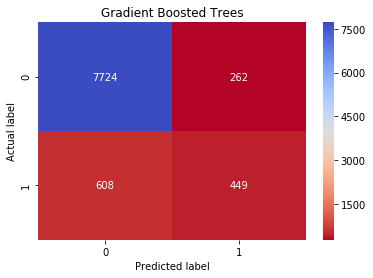

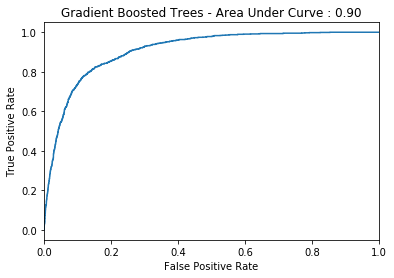

Area Under Curve : 0.908717857954353


In [14]:
print("\nBeginning to develop the first model, we begin with xgboost's gradient boosted trees.\n")

#Gradient Boosted Trees
gbt_param_grid = {'tree_method' : ['auto'],
                  'n_estimators' : [50, 100, 150], 
                  'max_depth' : [3, 5, 8, 10],
                  'min_child_weight' : [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2], 
                  'lambda' : [0.25, 0.5, 0.75, 1],
                  'learning_rate' : [0.001, 0.01, 0.1, 1.0], 
                  'class_weights' : [{0 : 1, 1 : 8.5}, {0: 1, 1 : 9}, {0 : 1, 1 : 8}]}


xgb_class = xgb.XGBClassifier(seed = 123)
gbt = GridSearchCV(xgb_class, gbt_param_grid, cv = kfold, n_jobs = -1, scoring = 'roc_auc')

gbt.fit(x_train, y_train)

print(f'Best score: {gbt.best_score_} with param: {gbt.best_params_}')

xgb_predictions = gbt.predict(x_test)

y_pred_prob = gbt.predict_proba(x_test)[::, 1]



#Retrieves accuracy, precision, F1 scores and AUC scores for strongest performing xgboost model
prediction_results(xgb_predictions, 'Gradient Boosted Trees', y_pred_prob)

Best score: 0.9098078874410991 with param: {'boosting_type': 'gbdt', 'class_weight': {0: 1, 1: 8.5}, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'num_leaves': 15, 'objective': 'binary'}
Accuracy: 0.8118987061815769
              precision    recall  f1-score   support

           0       0.98      0.81      0.88      7986
           1       0.37      0.86      0.52      1057

   micro avg       0.81      0.81      0.81      9043
   macro avg       0.67      0.83      0.70      9043
weighted avg       0.91      0.81      0.84      9043



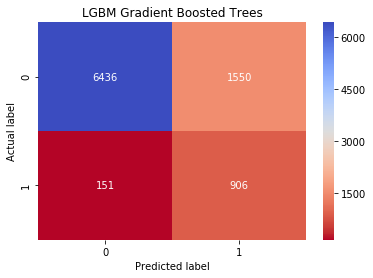

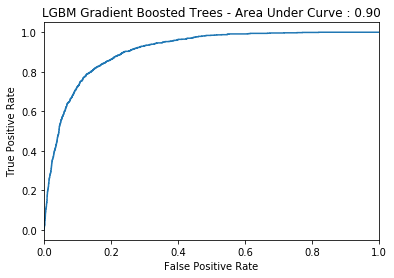

Area Under Curve : 0.909794244942841


In [15]:
#LightGBM
#Full list of parameters
lgbm_param_grid = {'objective' : ['binary'],
                   'boosting_type' : ['gbdt', 'dart'],
                   'n_estimators' : [50, 100, 150, 250],
                   'num_leaves' : [5, 10, 15, 20, 25, 30, 50, 70, 80],
                   'min_child_weight' : [0.1, 0.5, 1, 1.5, 2],   
                   'max_depth' : [5], 
                   'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1.0], 
                   'class_weight' : [{0 : 1, 1 : 8}, {0 : 1, 1 : 8.5}, {0 : 1, 1 : 9}]}    
         

lgbm_class = lightgbm.LGBMClassifier(random_state = 123)
lgbm = GridSearchCV(lgbm_class, lgbm_param_grid, cv = kfold, n_jobs = -1, scoring = 'roc_auc')

lgbm.fit(x_train, y_train)

print(f'Best score: {lgbm.best_score_} with param: {lgbm.best_params_}')

lgbm_predictions = lgbm.predict(x_test)

y_pred_prob = lgbm.predict_proba(x_test)[::, 1]

prediction_results(lgbm_predictions, 'LGBM Gradient Boosted Trees', y_pred_prob)